In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import find_peaks
import json
import math

---
# MUSIC for DOA estimation
##  Assignment 1 - Basic Implementation

### Introduction

#### Definitions

__MUSIC__ stands for Multiple Signal Classification and is an algorithm proposed by Schmidt and his colleagues in 1979

__DOA__ stands for Direction of Arrival

#### Goal

MUSIC can be used without modification for the estimation of DOA, assuming that there is a known number of sources and that the sources are uncorrelated. The goal of this mini-project is to compare a basic implementation of the MUSIC algorithm for DOA and an improved version, both for real/simulated and correlated/uncorrelated data.

#### Basic idea 

The basic idea of MUSIC algorithm is to conduct characteristic decomposition for the covariance matrix of any array output data, resulting in a __signal subspace__ orthogonal with a __noise subspace__ corresponding to the signal components. Then these two orthogonal subspaces are used to constitute a __spectrum function__, be got though by spectral peak search and detect DOA signals.

<img src="images/schema.png" alt="Schema" style="width: 400px;"/>

### Setup

#### Parameters

In [2]:
angles = [20., 60., -30., -35.]
freqs = [1/2, 1/3, 1/5, 1/10]

thetas = np.array(angles) / 180 * np.pi  # Incoming signal directions 
w = np.array(freqs)*2*np.pi              # Emitted frequencies corresponding to incoming signals
N = 200                                  # snapshots (number of samples)
M = 10                                   # number of receivers/mics
D = np.size(thetas)                      # number of sources
wavelen = 150                            # wavelength (in nm)
d = wavelen / 2                          # distance between mics
var = 0.10                               # variance of noise

#### Generate data

Far-field assumption TODO

First we generate the assignment matrix

<img src="images/matrix_A.png" alt="Matrix A" style="width: 400px;"/>

In [3]:
A = np.exp(-1j * 2 * np.pi * d/wavelen * np.kron(np.arange(M), np.sin(thetas)).reshape((M, D)))
print("A is a {} matrix".format(A.shape))

A is a (10, 4) matrix


It corresponds to the 4 generated signals received by each of the 10 microphones.

We now have to generate the matrix S, where

<img src="images/matrix_S(1).png" alt="Matrix S(1)" style="width: 200px;"/>

<img src="images/matrix_S(2).png" alt="Matrix S" style="width: 700px;"/>

In [4]:
S = 2 * np.exp(1j * (np.kron(w, np.arange(N)).reshape((D, N))))
print("S is a {} matrix".format(S.shape))

S is a (4, 200) matrix


The __noise__ is generated as follows

In [5]:
Noise = var * np.random.randn(M, N)
print("Noise is a {} matrix".format(Noise.shape))

Noise is a (10, 200) matrix


The __output signal matrix__ can therefore be computed as follows

<img src="images/matrix_X(0).png" alt="Matrix X(0)" style="width: 100px;"/>

where

<img src="images/matrix_X(1).png" alt="Matrix X(1)" style="width: 200px;"/>

and

<img src="images/matrix_X(2).png" alt="Matrix X(2)" style="width: 300px;"/>

In [6]:
X = np.dot(A, S) + Noise
print("X is a {} matrix".format(X.shape))

X is a (10, 200) matrix


Let's define a function to generate data:

In [7]:
def generate_data(M, N, d, wavelen, angles, freqs, var=0.01):
    thetas = np.array(angles) / 180 * np.pi
    w = np.array(freqs)*2*np.pi 
    D = np.size(thetas)
    A = np.exp(-1j * 2 * np.pi * d/wavelen * np.kron(np.arange(M), np.sin(thetas)).reshape((M, D)))
    S = 2 * np.exp(1j * (np.kron(w, np.arange(N)).reshape((D, N))))
    Noise = var * np.random.randn(M, N)
    X = np.dot(A, S) + Noise
    return X

### Basic Music for DOA Implementation for generated data

Let us now implement the basic MUSIC algorithm for DOA as described in *DOA Estimation Based on MUSIC Algorithm.pdf* by Honghao Tang.

In [8]:
def basic_musicDOA(X, M, d, wavelen, resscale="log"):
    D = np.size(thetas)
    
    # Make sure we have more receivers than input signals
    assert(M > D)
    
    # Peak search range (start degree, end degree, step)
    peak_search_range = np.arange(-90, 90, 0.5)
    
    # Center the output signal
    X_centered = (X.T - X.T.mean(axis=0)).T
    
    # Data covariance matrix: R = XX'
    R = np.dot(X_centered, X_centered.conj().T)
    
    # Eigen values decomposition of R
    eig_val, eig_vect = np.linalg.eig(R)
    
    # Find the smallest eigenvalues
    ids = np.abs(eig_val).argsort()[:(M-D)]  
    En = eig_vect[:,ids]
    
    # Noise subspace estimation: Ren = EnEn'
    Ren = np.dot(En, En.conj().T)

    # L = future size of Pmusic
    L = np.size(peak_search_range)
    
    # 
    a = np.exp(-1j * 2 * np.pi * d/wavelen * np.kron(np.arange(M), np.sin(peak_search_range * np.pi /180)).reshape(M, L))
    
    # Pmusic = a(peak_search_range)' * En * En' * a(peak_search_range)
    Pmusic = np.zeros(L)
    for i in range(L):
        Pmusic[i] = 1/abs(np.dot(a[:, i].conj().T, np.dot(Ren, a[:, i])))

    # Spatial spectrum function
    if resscale == "log":
        Pmusic = 10 * np.log10(Pmusic / np.max(Pmusic))    
    
    return Pmusic, peak_search_range

### Plot the results

In [9]:
Pmusic, peak_search_range = basic_musicDOA(X, M, d, wavelen)

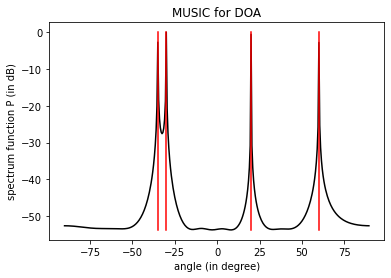

In [10]:
plt.plot(peak_search_range, Pmusic, '-k')
plt.xlabel('angle (in degree)')
plt.ylabel('spectrum function P (in dB)')
plt.title('MUSIC for DOA')
for angle in angles:
        plt.plot((angle, angle), (Pmusic.min(), Pmusic.max()), 'r')
plt.show()

In [11]:
def find_angles(Pmusic, peak_search_range, prominence=10, width=1):
    peaks, _ = find_peaks(Pmusic, prominence=prominence, width=width)
    peaks = peaks*abs(peak_search_range[2]-peak_search_range[1]) + peak_search_range[0]
    print("Angle found are: ", peaks)
    print(np.sum(np.sort(np.array(peaks)) == np.sort(np.array(angles))), "/", len(peaks), " correct guesses")
    return peaks

In [12]:
find_angles(Pmusic, peak_search_range)

Angle found are:  [-35. -30.  20.  60.]
4 / 4  correct guesses


array([-35., -30.,  20.,  60.])

### Comparison of results for correlated and uncorrelated data

In [13]:
true_angles = {"Wide Angles":[10, 40, 70], 
              "Close Angles":[10, 15, 20],}
frequencies = {"Uncorrelated Frequencies":[1/2, 1/5, 1/10],
              "Correlated Frequencies 1/5":[1/5, 1/5, 1/5],
              "Correlated Frequencies 1/2":[1/2, 1/2, 1/2]}

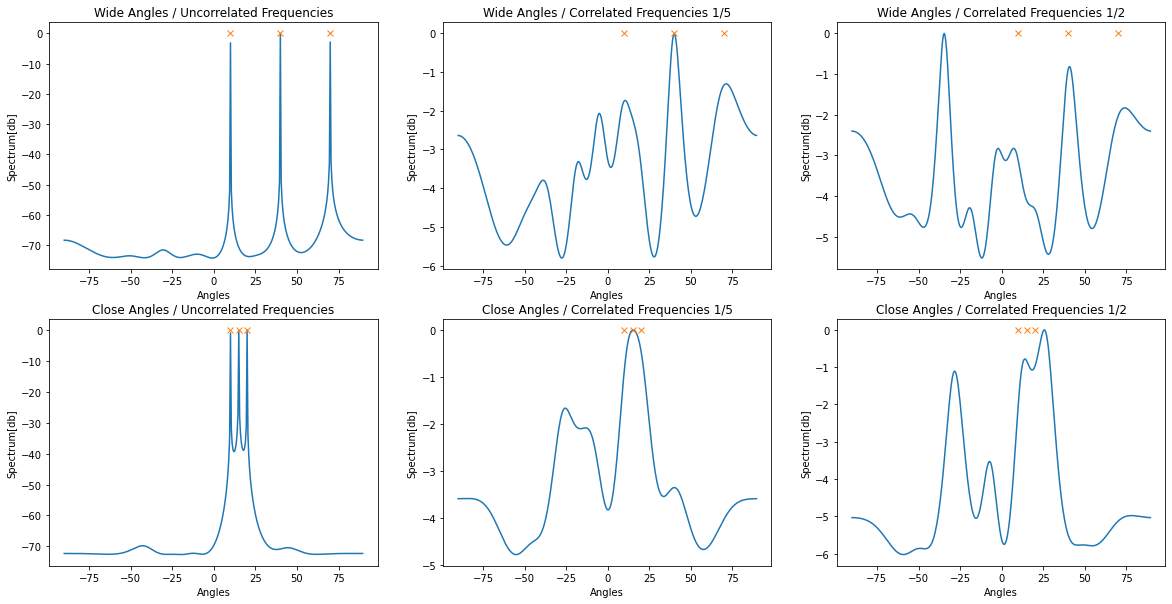

In [14]:
plt.figure(figsize=((20,10)))
index = 0
plotIndex = str(len(true_angles)) + str(len(frequencies)) + '1'
for i in true_angles.items():
    for j in frequencies.items():
        X = generate_data(M, N, d, wavelen, i[1], j[1])
        Pmusic, angle_range = basic_musicDOA(X, M, d, wavelen)
        plt.subplot(int(plotIndex) + index)
        plt.plot(angle_range, Pmusic)
        plt.title((str(i[0]) + " / " + str(j[0])))
        plt.plot(i[1],(0,0,0),"x")
        plt.xlabel("Angles")
        plt.ylabel("Spectrum[db]")
        index += 1
plt.show()

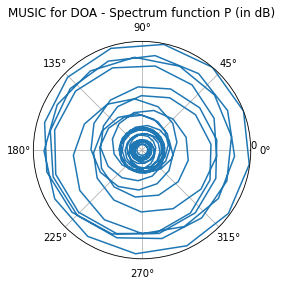

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)

# only show -50dB, -30dB, 0dB ticks
ax.set_yticks([-50, -30, 0])
ax.set_rlabel_position(0)

plt.plot(peak_search_range, Pmusic)
plt.title('MUSIC for DOA - Spectrum function P (in dB)')
plt.show()